In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, roc_auc_score

# The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan.

## Read the dataset

In [3]:
train_data = pd.read_csv("./application_train.csv")
test_data = pd.read_csv("./application_test.csv")
#train_data.head()

In [4]:
bureau = pd.read_csv("./bureau.csv")
#bureau.head()

In [5]:
pos_balance = pd.read_csv("./POS_CASH_balance.csv")
#pos_balance.head()

In [6]:
pte_appli = pd.read_csv("./previous_application.csv")
#pte_appli.head()

In [7]:
credit = pd.read_csv("./credit_card_balance.csv")
#credit.head()

# Exploratory Data Analysis

In [8]:
train_data.TARGET.value_counts() ## imbalanced data
#train_data.dtypes

0    282686
1     24825
Name: TARGET, dtype: int64

## Label Encoding and One-Hot Encoding

In [9]:
#Label Encoding
le = LabelEncoder()

# Iterate through the columns
for col in train_data:
    if train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_data[col])
            # Transform both training and testing data
            train_data[col] = le.transform(train_data[col])
            test_data[col] = le.transform(test_data[col])

# one-hot encoding of categorical variables
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

print('Training dataset shape: ', train_data.shape)
print('Testing dataset shape: ', test_data.shape)

Training dataset shape:  (307511, 243)
Testing dataset shape:  (48744, 239)


In [10]:
# Align training data and testing data together
labels = train_data['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
train_data, test_data = train_data.align(test_data, join = 'inner', axis = 1)

# Add the target back in
train_data['TARGET'] = labels

print('Training Features shape: ', train_data.shape)
print('Testing Features shape: ', test_data.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## To see if there is anomaly in the dataset

In [11]:
train_data['DAYS_EMPLOYED'].describe() # How many days before the application the person started current employment

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

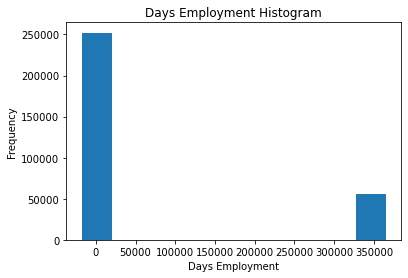

In [12]:
train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

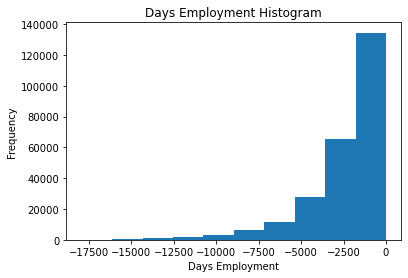

In [13]:
# Create an anomalous flag column
train_data['DAYS_EMPLOYED_ANOM'] = train_data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
train_data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

train_data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');
# now the data seems much more normal than before

In [14]:
# same procedure to testing dataset
test_data['DAYS_EMPLOYED_ANOM'] = test_data["DAYS_EMPLOYED"] == 365243
test_data["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# Feature Engineering

## Features from other datasets

In [15]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
# DPD (days past due) during the month of previous credit
pos_data = pos_balance.groupby(['SK_ID_CURR'], as_index = False)["SK_DPD"].mean().rename(columns = {'SK_DPD': 'mean_of_SK_DPD'})
# Interest rate normalized on previous credit
pte_data = pte_appli.groupby(['SK_ID_CURR'], as_index = False)['RATE_INTEREST_PRIVILEGED'].mean().rename(columns = {'RATE_INTEREST_PRIVILEGED': 'mean_of_RATE_INTEREST_PRIVILEGED'})
#Credit card limit during the month of the previous credit
credit_data = credit.groupby(['SK_ID_CURR'], as_index = False)['AMT_CREDIT_LIMIT_ACTUAL'].mean().rename(columns = {'AMT_CREDIT_LIMIT_ACTUAL': 'mean_of_AMT_CREDIT_LIMIT_ACTUAL'})
#Balance during the month of previous credit
balance_data = credit.groupby(['SK_ID_CURR'], as_index = False)['AMT_BALANCE'].mean().rename(columns = {'AMT_BALANCE': 'mean_of_AMT_BALANCE'})



In [16]:
# Join to the training dataframe from other dataset
train_data = train_data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
train_data = train_data.merge(pos_data, on = 'SK_ID_CURR', how = 'left')
train_data = train_data.merge(pte_data, on = 'SK_ID_CURR', how = 'left')
train_data = train_data.merge(credit_data, on = 'SK_ID_CURR', how = 'left')
train_data = train_data.merge(balance_data, on = 'SK_ID_CURR', how = 'left')


# Fill the missing values with 0 
train_data['previous_loan_counts'] = train_data['previous_loan_counts'].fillna(0)
train_data['mean_of_SK_DPD'] = train_data['mean_of_SK_DPD'].fillna(0)
train_data['mean_of_RATE_INTEREST_PRIVILEGED'] = train_data['mean_of_RATE_INTEREST_PRIVILEGED'].fillna(0)
train_data['mean_of_AMT_CREDIT_LIMIT_ACTUAL'] = train_data['mean_of_AMT_CREDIT_LIMIT_ACTUAL'].fillna(0)
train_data['mean_of_AMT_BALANCE'] = train_data['mean_of_AMT_BALANCE'].fillna(0)


train_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,previous_loan_counts,mean_of_SK_DPD,mean_of_RATE_INTEREST_PRIVILEGED,mean_of_AMT_CREDIT_LIMIT_ACTUAL,mean_of_AMT_BALANCE
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,1,0,1,False,8.0,0.0,0.0,0.0,0.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,1,0,0,False,4.0,0.0,0.0,0.0,0.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,False,2.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,False,0.0,0.0,0.0,270000.0,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,False,1.0,0.0,0.0,0.0,0.0


In [17]:
# do the same thing for testing dataset
test_data = test_data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
test_data = test_data.merge(pos_data, on = 'SK_ID_CURR', how = 'left')
test_data = test_data.merge(pte_data, on = 'SK_ID_CURR', how = 'left')
test_data = test_data.merge(credit_data, on = 'SK_ID_CURR', how = 'left')
test_data = test_data.merge(balance_data, on = 'SK_ID_CURR', how = 'left')


# Fill the missing values with 0 
test_data['previous_loan_counts'] = test_data['previous_loan_counts'].fillna(0)
test_data['mean_of_SK_DPD'] = test_data['mean_of_SK_DPD'].fillna(0)
test_data['mean_of_RATE_INTEREST_PRIVILEGED'] = test_data['mean_of_RATE_INTEREST_PRIVILEGED'].fillna(0)
test_data['mean_of_AMT_CREDIT_LIMIT_ACTUAL'] = test_data['mean_of_AMT_CREDIT_LIMIT_ACTUAL'].fillna(0)
test_data['mean_of_AMT_BALANCE'] = test_data['mean_of_AMT_BALANCE'].fillna(0)


#test_data.head()

## Domain Knowledge Features

In [18]:
train_data['CREDIT_INCOME_PERCENT'] = train_data['AMT_CREDIT'] / train_data['AMT_INCOME_TOTAL']
train_data['ANNUITY_INCOME_PERCENT'] = train_data['AMT_ANNUITY'] / train_data['AMT_INCOME_TOTAL']
test_data['CREDIT_INCOME_PERCENT'] = test_data['AMT_CREDIT'] / test_data['AMT_INCOME_TOTAL']
test_data['ANNUITY_INCOME_PERCENT'] = test_data['AMT_ANNUITY'] / test_data['AMT_INCOME_TOTAL']

In [19]:
# Find correlations with the target and sort
correlations = train_data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
mean_of_AMT_BALANCE                                  0.048523
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

# Preprocessing for missing data and standardizing

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

In [21]:
# Extract the ids
train_ids = train_data['SK_ID_CURR']
test_ids = test_data['SK_ID_CURR']

# Drop the ids and target from the training data
train = train_data.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test_data.drop(columns = ['SK_ID_CURR'])

# Extract feature names
features = list(train.columns)

In [22]:
## Missing data

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

In [23]:
## Standardizing
# Standardize the dataset’s features onto unit scale (mean = 0 and variance = 1)

# fit on the training set and transform on the training and test set.
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [24]:
print('Training data features shape: ', train.shape)
print('Testing data features shape: ', test.shape)

Training data features shape:  (307511, 246)
Testing data features shape:  (48744, 246)


# No feature selection

In [25]:
train_all = train.copy()
test_all = test.copy()
print('Training data features shape: ', train_all.shape)
print('Testing data features shape: ', test_all.shape)

Training data features shape:  (307511, 246)
Testing data features shape:  (48744, 246)


# Feature Selection -- PCA

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(0.95) # choose the minimum number of principal components such that 95% of the variance is retained
# Fit PCA on training set.
pca.fit(train) # fitting PCA on the training set only
# Apply the mapping to both the training set and the testing set.
train = pca.transform(train)
test = pca.transform(test)

In [28]:
print('Training data features shape: ', train.shape)
print('Testing data features shape: ', test.shape)

Training data features shape:  (307511, 173)
Testing data features shape:  (48744, 173)


# Model Construction

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.001)
log_reg_all = LogisticRegression(C = 0.001)

# Train on the training data
log_reg.fit(train, labels) # labels = train_data['TARGET']
log_reg_all.fit(train_all, labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]
log_reg_pred_all = log_reg_all.predict_proba(test_all)[:, 1]

In [30]:
# Submission dataframe
submit_logistic = test_data[['SK_ID_CURR']]
submit_logistic['TARGET'] = log_reg_pred

submit_logistic_all = test_data[['SK_ID_CURR']]
submit_logistic_all['TARGET'] = log_reg_pred_all

submit_logistic.to_csv('logistic regression.csv', index = False)
submit_logistic_all.to_csv('logistic regression_all.csv', index = False)

<ipython-input-30-acaf947ee859>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_logistic['TARGET'] = log_reg_pred
<ipython-input-30-acaf947ee859>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_logistic_all['TARGET'] = log_reg_pred_all


# Score: 0.73276 for logistic regression
# Score: 0.74354 for logistic regression without feature selection

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 60, random_state = 50, verbose = 1, n_jobs = -1, oob_score=True)
random_forest_all = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 60, random_state = 50, verbose = 1, n_jobs = -1, oob_score=True)

In [32]:
# Train on the training data
random_forest.fit(train, labels)
random_forest_all.fit(train_all, labels)

# Make predictions on the test data
predictions_rf = random_forest.predict_proba(test)[:, 1]
predictions_rf_all = random_forest_all.predict_proba(test_all)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [33]:
# Make a submission dataframe
submit_rf = test_data[['SK_ID_CURR']]
submit_rf['TARGET'] = predictions_rf
submit_rf_all = test_data[['SK_ID_CURR']]
submit_rf_all['TARGET'] = predictions_rf_all

# Save the submission dataframe
submit_rf.to_csv('random_forest.csv', index = False)
submit_rf_all.to_csv('random_forest_all.csv', index = False)

<ipython-input-33-39bcf5fa9e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_rf['TARGET'] = predictions_rf
<ipython-input-33-39bcf5fa9e39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit_rf_all['TARGET'] = predictions_rf_all


# Score: 0.69170 for random forest
# Score: 0.73162 for random forest without feature selection

## Lightgbm

In [38]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc

In [39]:
# Convert to np arrays
train = np.array(train)
test = np.array(test)
train_all = np.array(train_all)
test_all = np.array(test_all)

In [40]:
# Create the kfold object
n_folds = 5
k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

In [41]:
# Empty array for test predictions
test_predictions = np.zeros(test.shape[0])
test_predictions_all = np.zeros(test_all.shape[0])

# Empty array for out of fold validation predictions
out_of_fold = np.zeros(train.shape[0])
out_of_fold_all = np.zeros(train_all.shape[0])

# Lists for recording validation and training scores
valid_scores = []
train_scores = []

In [42]:
# For selected features via PCA
# Iterate through each fold
for train_indices, valid_indices in tqdm(k_fold.split(train)):

    # Training data for the fold
    train_features, train_labels = train[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train[valid_indices], labels[valid_indices]

    # Create the model
    model = lgb.LGBMClassifier(n_estimators=5000, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, max_depth = 6,
                               subsample = 0.8, n_jobs = -1, random_state = 50)

    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'],
              early_stopping_rounds = 100, verbose = 200)

    # Record the best iteration
    best_iteration = model.best_iteration_

    # Make predictions
    test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

    # Record the out of fold predictions
    out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

    # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

0it [00:00, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.802448	train's binary_logloss: 0.555706	valid's auc: 0.729067	valid's binary_logloss: 0.57451
[400]	train's auc: 0.842752	train's binary_logloss: 0.514152	valid's auc: 0.730231	valid's binary_logloss: 0.547259
Early stopping, best iteration is:
[332]	train's auc: 0.830757	train's binary_logloss: 0.526459	valid's auc: 0.730611	valid's binary_logloss: 0.555065


1it [00:27, 27.01s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.802684	train's binary_logloss: 0.555683	valid's auc: 0.730692	valid's binary_logloss: 0.574228
[400]	train's auc: 0.842917	train's binary_logloss: 0.514101	valid's auc: 0.733681	valid's binary_logloss: 0.546386
Early stopping, best iteration is:
[431]	train's auc: 0.847847	train's binary_logloss: 0.508888	valid's auc: 0.73393	valid's binary_logloss: 0.542874


2it [00:57, 29.32s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.802138	train's binary_logloss: 0.556337	valid's auc: 0.731092	valid's binary_logloss: 0.576559
[400]	train's auc: 0.84245	train's binary_logloss: 0.51497	valid's auc: 0.733342	valid's binary_logloss: 0.549222
Early stopping, best iteration is:
[324]	train's auc: 0.828901	train's binary_logloss: 0.528764	valid's auc: 0.734127	valid's binary_logloss: 0.557992


3it [01:25, 28.51s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.801946	train's binary_logloss: 0.556536	valid's auc: 0.733455	valid's binary_logloss: 0.573076
[400]	train's auc: 0.842667	train's binary_logloss: 0.514851	valid's auc: 0.735549	valid's binary_logloss: 0.545624
Early stopping, best iteration is:
[377]	train's auc: 0.838685	train's binary_logloss: 0.518878	valid's auc: 0.735744	valid's binary_logloss: 0.54821


4it [01:54, 28.74s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.802878	train's binary_logloss: 0.55542	valid's auc: 0.731768	valid's binary_logloss: 0.575741
[400]	train's auc: 0.843301	train's binary_logloss: 0.513771	valid's auc: 0.7327	valid's binary_logloss: 0.548635
Early stopping, best iteration is:
[317]	train's auc: 0.828284	train's binary_logloss: 0.52894	valid's auc: 0.733562	valid's binary_logloss: 0.558428


5it [02:20, 28.19s/it]


In [43]:
# Make the submission dataframe
submission_lgbm = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

In [44]:
submission_lgbm.to_csv('lgbm.csv', index = False)

### For all features without selection

In [45]:
# Iterate through each fold
valid_scores = []
train_scores = []

for train_indices, valid_indices in tqdm(k_fold.split(train_all)):

    # Training data for the fold
    train_features, train_labels = train_all[train_indices], labels[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_all[valid_indices], labels[valid_indices]

    # Create the model
    model = lgb.LGBMClassifier(n_estimators=5000, objective = 'binary', 
                               class_weight = 'balanced', learning_rate = 0.05, 
                               reg_alpha = 0.1, reg_lambda = 0.1, max_depth = 6,
                               subsample = 0.8, n_jobs = -1, random_state = 50)

    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'],
              early_stopping_rounds = 100, verbose = 200)

    # Record the best iteration
    best_iteration = model.best_iteration_

    # Make predictions
    test_predictions_all += model.predict_proba(test_all, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

    # Record the out of fold predictions
    out_of_fold_all[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

    # Record the best score
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    # Clean up memory
    gc.enable()
    del model, train_features, valid_features
    gc.collect()

0it [00:00, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.799108	train's binary_logloss: 0.547861	valid's auc: 0.75824	valid's binary_logloss: 0.561723
[400]	train's auc: 0.826194	train's binary_logloss: 0.519572	valid's auc: 0.759879	valid's binary_logloss: 0.543983
Early stopping, best iteration is:
[439]	train's auc: 0.830942	train's binary_logloss: 0.514531	valid's auc: 0.760095	valid's binary_logloss: 0.541025


1it [00:22, 22.09s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798789	train's binary_logloss: 0.548417	valid's auc: 0.760485	valid's binary_logloss: 0.561724
Early stopping, best iteration is:
[293]	train's auc: 0.812421	train's binary_logloss: 0.534234	valid's auc: 0.761223	valid's binary_logloss: 0.553321


2it [00:37, 18.30s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79783	train's binary_logloss: 0.549446	valid's auc: 0.765784	valid's binary_logloss: 0.562599
[400]	train's auc: 0.825053	train's binary_logloss: 0.521242	valid's auc: 0.767038	valid's binary_logloss: 0.544855
Early stopping, best iteration is:
[365]	train's auc: 0.820763	train's binary_logloss: 0.52575	valid's auc: 0.767292	valid's binary_logloss: 0.54754


3it [00:55, 18.07s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798323	train's binary_logloss: 0.548877	valid's auc: 0.761415	valid's binary_logloss: 0.561163
Early stopping, best iteration is:
[295]	train's auc: 0.812589	train's binary_logloss: 0.534115	valid's auc: 0.763043	valid's binary_logloss: 0.551844


4it [01:11, 17.34s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79874	train's binary_logloss: 0.548347	valid's auc: 0.761322	valid's binary_logloss: 0.563003
[400]	train's auc: 0.826424	train's binary_logloss: 0.519552	valid's auc: 0.76268	valid's binary_logloss: 0.54552
Early stopping, best iteration is:
[364]	train's auc: 0.821945	train's binary_logloss: 0.524249	valid's auc: 0.762851	valid's binary_logloss: 0.548286


5it [01:30, 18.02s/it]


In [46]:
# Make the submission dataframe
submission_lgbm_all = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions_all})

In [47]:
submission_lgbm_all.to_csv('lgbm_all.csv', index = False)

# Score: 0.72514 for LightGBM
# Score: 0.75137 for LightGBM without feature selection

# Conclusion

## PCA is a good way to select linear related features, and we can see that logistic regression performs really well in this case.
## While PCA may miss some features that have non-linear relation with the target, we find that without feature selections, these three models all perform better than selected features which indicate that most of our features have non-linear relations with the target.